# LAB3 IA Generativa - Imágenes
# Lucía Chicharro, María Montero y Patricia Ramos


## Ejercicio 1

Entrenar un Variational Autoencoder con la base de dados keras.datasets.fashion_mnist (con las imágenes de Zalando). Una vez que entrenado el modelo, usar la red decoder para convertir vectores espaciales latentes arbitrarios en imágenes. (Mostrar un ejemplo del espacio latente)

Un autoencoder de imágenes clásico **toma una imagen**, la **asigna a un espacio vectorial latente a través de un módulo codificador** y luego **la decodifica a una salida con las mismas dimensiones que la imagen original**, a través de un **módulo decodificador**

Luego **se entrena utilizando como datos objetivo** las **mismas imágenes que las imágenes de entrada**, lo que significa que **el autoencoder aprende a reconstruir las entradas originales**.

**Red encoder VAE**

Convierte una imagen real en una media y
una varianza en el espacio latente

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Dimensionalidad del espacio latente: un plano 2D
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# La imagen de entrada termina siendo codificada
# en estos dos parámetros: z_mean y z_log_var
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

Generamos un punto espacial latente usando la media y la varianza.

In [ ]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Dibuja un lote de vectores normales aleatorios.
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        # Aplicar la fórmula de muestreo VAE
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**Red de decodificadores VAE**

Convierte los puntos del espacio latente en imágenes

In [ ]:
# Entrada a través de la cual alimentaremos con z
latent_inputs = keras.Input(shape=(latent_dim,))
# Producimos la misma cantidad de coeficientes que
# teníamos al nivel de la capa Flatten en el codificador.
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# Revertimos la capa Flatten del codificador.
x = layers.Reshape((7, 7, 64))(x)
# Revertimos las capas Conv2D del codificador.
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# La salida termina con la forma (28, 28, 1)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

**Creamos el propio VAE**

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # Usamos estas métricas para realizar un seguimiento
        # de los promedios de pérdida en cada época.
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    # Listamos las métricas en la propiedad metrics para permitir
    # que el modelo las restablezca después de cada época (o entre
    # varias llamadas a fit()/evaluate())
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # Sumamos la pérdida de reconstrucción sobre las
            # dimensiones espaciales (ejes 1 y 2) y tomamos
            # su media sobre la dimensión del lote.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # Agreguamos el término de regularización
            # (divergencia de Kullback-Leibler).
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Importamos los datos de `fashion_mnist`.

In [ ]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
# concatenamos las muestras
fashion_mnist = np.concatenate([x_train, x_test], axis=0)
fashion_mnist = np.expand_dims(fashion_mnist, -1).astype("float32") / 255

In [ ]:
vae = VAE(encoder, decoder)
# Notemos que no pasamos un argumento de pérdida a compile(),
# ya que la pérdida ya es parte de train_step()
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
# Notemos que no pasamos objetivos (targets) en fit(),
# ya que train_step() no espera ninguno

Entrenamos el modelo

In [ ]:
vae.fit(fashion_mnist, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 41s 71ms/step - total_loss: 258.7306 - reconstruction_loss: 254.9357 - kl_loss: 3.7950
Epoch 2/30
547/547 [==============================] - 35s 64ms/step - total_loss: 258.4762 - reconstruction_loss: 254.6764 - kl_loss: 3.8001
Epoch 3/30
547/547 [==============================] - 39s 72ms/step - total_loss: 258.2599 - reconstruction_loss: 254.4674 - kl_loss: 3.7926
Epoch 4/30
547/547 [==============================] - 33s 61ms/step - total_loss: 258.0587 - reconstruction_loss: 254.2597 - kl_loss: 3.7992
Epoch 5/30
547/547 [==============================] - 39s 72ms/step - total_loss: 258.0038 - reconstruction_loss: 254.1998 - kl_loss: 3.8040
Epoch 6/30
547/547 [==============================] - 33s 61ms/step - total_loss: 257.6909 - reconstruction_loss: 253.8789 - kl_loss: 3.8120
Epoch 7/30
547/547 [==============================] - 32s 59ms/step - total_loss: 257.5515 - reconstruction_loss: 253.7391 - kl_loss: 3.8125
Epoch 8/30
54

Veamos si aumentando las épocas se consigue un mejor resultado.

In [ ]:
vae2 = VAE(encoder, decoder)
vae2.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae2.fit(fashion_mnist, epochs=35, batch_size=128)

Epoch 1/35
547/547 [==============================] - 33s 58ms/step - total_loss: 255.3326 - reconstruction_loss: 251.4675 - kl_loss: 3.8651
Epoch 2/35
547/547 [==============================] - 32s 58ms/step - total_loss: 255.3083 - reconstruction_loss: 251.4250 - kl_loss: 3.8833
Epoch 3/35
547/547 [==============================] - 31s 56ms/step - total_loss: 255.2512 - reconstruction_loss: 251.3647 - kl_loss: 3.8864
Epoch 4/35
547/547 [==============================] - 31s 56ms/step - total_loss: 255.1653 - reconstruction_loss: 251.2830 - kl_loss: 3.8824
Epoch 5/35
547/547 [==============================] - 31s 57ms/step - total_loss: 255.0958 - reconstruction_loss: 251.2171 - kl_loss: 3.8787
Epoch 6/35
547/547 [==============================] - 31s 56ms/step - total_loss: 255.0652 - reconstruction_loss: 251.1740 - kl_loss: 3.8911
Epoch 7/35
547/547 [==============================] - 30s 56ms/step - total_loss: 255.0525 - reconstruction_loss: 251.1690 - kl_loss: 3.8834
Epoch 8/35
54

Una vez que se entrena el modelo, podemos **usar la red ``decoder``** para **convertir vectores espaciales latentes arbitrarios en imágenes**.

**Muestreo de una cuadrícula de imágenes del espacio latente 2D**

1/1 [==============================] - 0s 18ms/step


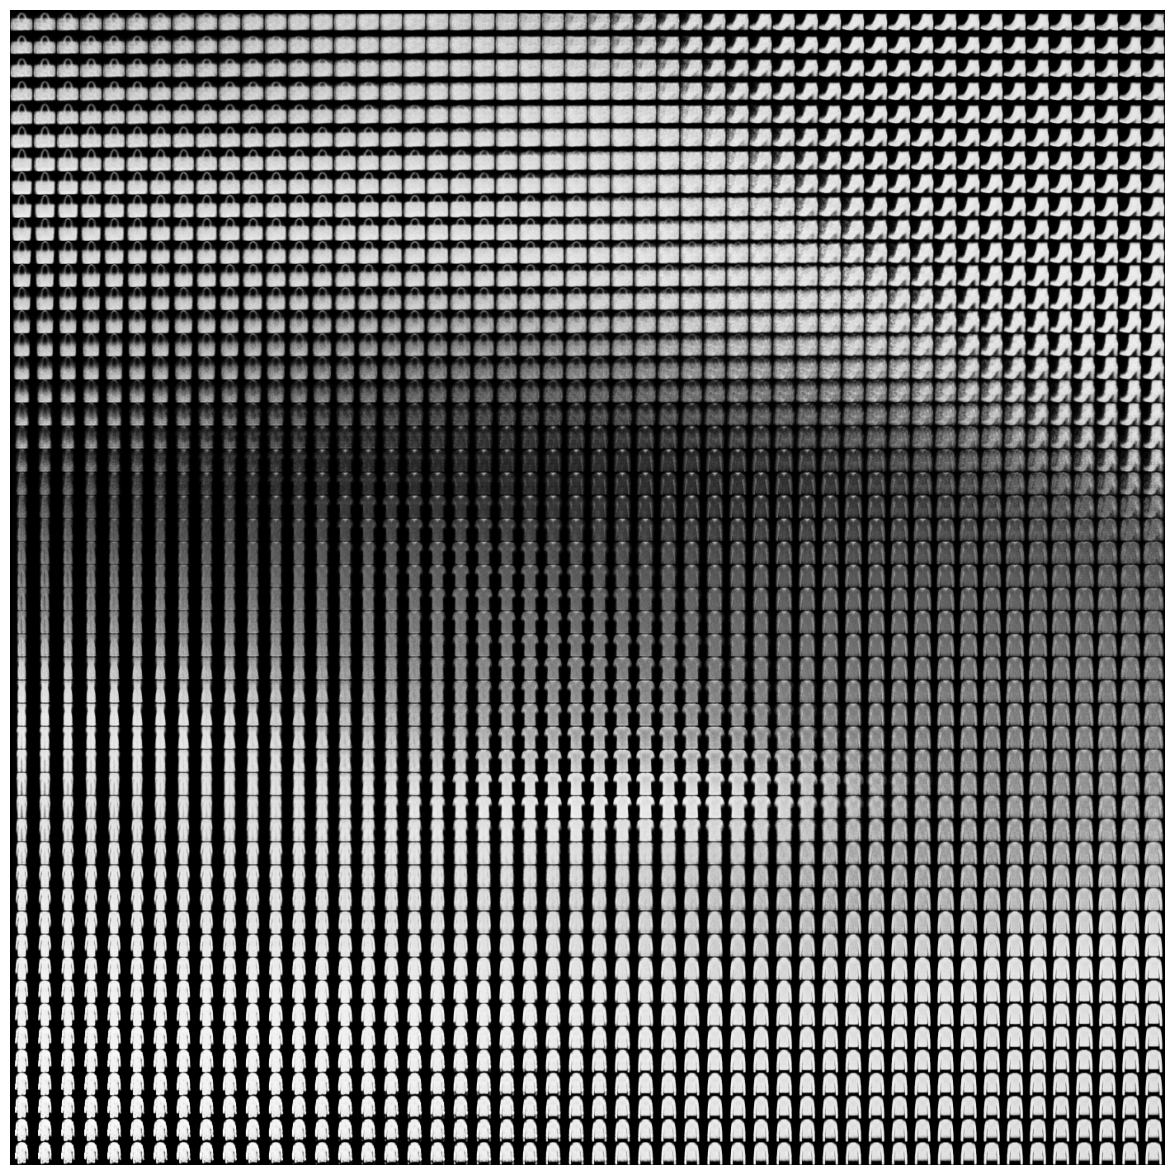

In [ ]:
import matplotlib.pyplot as plt

# Mostraremos una cuadrícula de
# 50 × 50
n = 50
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Muestree de puntos linealmente en una cuadrícula 2D.
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Para cada ubicación, muestreamos un
        # dígito y lo agregamos a nuestra figura
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

1/1 [==============================] - 0s 18ms/step


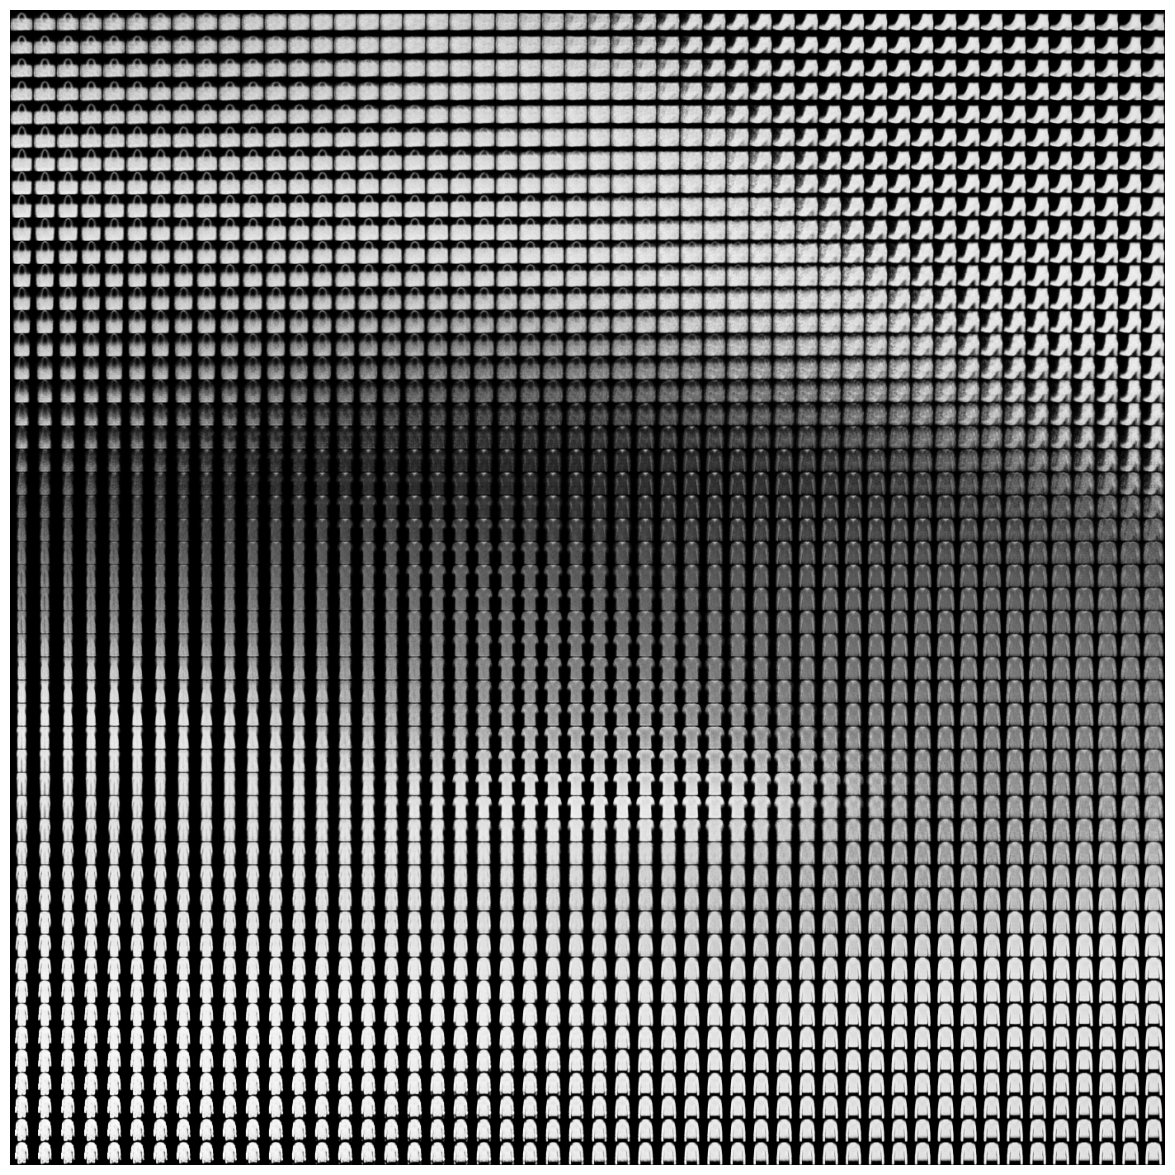

In [ ]:
import matplotlib.pyplot as plt

# Mostraremos una cuadrícula de
# 50 × 50
n = 50
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Muestree de puntos linealmente en una cuadrícula 2D.
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Para cada ubicación, muestreamos un
        # dígito y lo agregamos a nuestra figura
        z_sample = np.array([[xi, yi]])
        x_decoded = vae2.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

Podemos ver una distribución de las diferentes prendas de manera que si por ejemplo comenzamos con una camiseta de manga larga (esquina inferior derecha), desplazándonos hacia la izquierda se consigue un vestido o en diagonal una camiseta de manga corta. De la misma manera si partimos de un bolso (esquina superior izquierda) si nos desplazamos hacia la derecha se logra unas botas.

## Ejercicio 2

Dada la siguiente base de datos de zapatos (https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip). Entrenar una GAN para generar imágenes de zapatos nuevas.

In [ ]:
import os
import zipfile
import urllib.request

url = "https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip"

# Directorio donde se guardará el archivo
save_dir = "./ut-zap50k-images-square"
os.makedirs(save_dir, exist_ok=True)

# Descargar el archivo ZIP
zip_file_path = os.path.join(save_dir, "ut-zap50k-images-square.zip")
urllib.request.urlretrieve(url, zip_file_path)

# Extraer el archivo ZIP
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(save_dir)

**Creamos un dataset a partir de un directorio de imágenes**

In [ ]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "./ut-zap50k-images-square",
    # Solo se devolverán las imágenes, sin etiquetas.
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    # Cambiaremos el tamaño de las imágenes a 64 × 64
    # usando una combinación inteligente de recorte y
    # cambio de tamaño para preservar la relación de
    # aspecto. ¡No queremos que las proporciones
    # de la cara se distorsionen!
    smart_resize=True)

Found 50066 files belonging to 1 classes.


**Rescalamos las imágenes**

In [ ]:
dataset = dataset.map(lambda x: x / 255.)

**Mostramos la primera imagen**

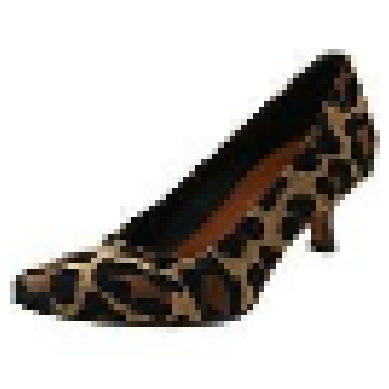

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### Discriminador

Toma una imagen candidata y la clasifica como "generada" (falsa) o "procedente del conjunto de entrenamiento"

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        # Una capa de Dropout: ¡un truco importante!
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

### Generador

Convierte un vector del espacio latente en una imagen candidata.

In [ ]:
# El espacio latente estará formado por vectores de 128 dimensiones.
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # Producimos la misma cantidad de coeficientes que teníamos
        # al nivel de la capa Flatten en el codificador.
        layers.Dense(8 * 8 * 128),
        # Revertimos la capa Flatten del codificador
        layers.Reshape((8, 8, 128)),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # La salida termina con la forma (28, 28, 1)
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

### Creamos la GAN

Para ello se encadena el generador y el discriminador.



**Ciclo de entranamiento esquemático**. Para cada época, hacemos lo siguiente:
1. **Dibujar puntos aleatorios en el espacio latente** (**ruido aleatorio**).
2. **Generamos imágenes con ``generator`` usando este ruido aleatorio**.
3. **Mezclamos** las **imágenes generadas** **con** las **reales**.
4. **Entrenamos al ``discriminator``** utilizando estas **imágenes mezcladas**, **con los objetivos correspondientes**: ya sea "**real**" (para las imágenes reales) o "**fake**" (para las **imágenes generadas**).
5. **Dibujamos nuevos puntos aleatorios en el espacio latente**.
6. **Entrenamos el ´´generator´´ usando estos vectores aleatorios**, con **objetivos que dicen "estas son imágenes reales"**. **Esto actualiza los pesos del generador para moverlos para que el discriminador prediga "estas son imágenes reales" para las imágenes generadas: esto entrena al generador para engañar al discriminador**.

In [ ]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # Configura métricas para rastrear las dos
        # pérdidas en cada época de entrenamiento
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Muestrea puntos aleatorios en el espacio latente
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # Los decodifica a imágenes falsas
        generated_images = self.generator(random_latent_vectors)
        # Los combina con imágenes reales
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Ensambla etiquetas, discriminando imágenes reales de falsas
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Agrega ruido aleatorio a las etiquetas: ¡un truco importante!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Entrenamos al discriminador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            # Muestrea puntos aleatorios en el espacio latente
            shape=(batch_size, self.latent_dim))

        # Ensambla etiquetas de imágenes reales
        misleading_labels = tf.zeros((batch_size, 1))

        # Entrena al generador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

**Una callback que muestra imágenes generadas durante el entrenamiento**

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

Entrenamos la GAN.

In [ ]:
# Comenzaremos a obtener resultados interesantes después de la época 20.
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100
1565/1565 [==============================] - 431s 267ms/step - d_loss: 0.5706 - g_loss: 1.1578
Epoch 2/100
1565/1565 [==============================] - 413s 264ms/step - d_loss: 0.6559 - g_loss: 0.9161
Epoch 3/100
1565/1565 [==============================] - 412s 263ms/step - d_loss: 0.6487 - g_loss: 0.9793
Epoch 4/100
1565/1565 [==============================] - 411s 262ms/step - d_loss: 0.6625 - g_loss: 0.9022
Epoch 5/100
1565/1565 [==============================] - 409s 262ms/step - d_loss: 0.6391 - g_loss: 1.0499
Epoch 6/100
1565/1565 [==============================] - 409s 261ms/step - d_loss: 0.6550 - g_loss: 0.9108
Epoch 7/100
1565/1565 [==============================] - 409s 262ms/step - d_loss: 0.6655 - g_loss: 0.9270
Epoch 8/100
1565/1565 [==============================] - 409s 261ms/step - d_loss: 0.6501 - g_loss: 0.9905
Epoch 9/100
1565/1565 [==============================] - 410s 262ms/step - d_loss: 0.6464 - g_loss: 0.9684
Epoch 10/100
1565/1565 [=============

KeyboardInterrupt: 

Paramos la ejecución a partir de la época 20 y observamos los resultados.

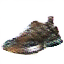

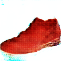

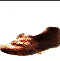

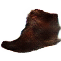

Como se puede observar, a partir de imágenes del dataset original es capaz de generar nuevas imágenes con algunas características distorsionadas (principalmente el color )pero que se parecen bastante a las originales.